# Capítulo 2: Análisis: Reuniéndolo todo y tomando decisiones

## Ejemplos
        Análisis quintil: con datos aleatorios
El análisis de quintiles es un marco común para evaluar la eficacia de los factores de seguridad.

        ¿Qué es un factor?

Un factor es un método para calificar/clasificar conjuntos de valores. Para un momento particular en el tiempo y para un conjunto particular de valores, un factor se puede representar como una serie de pandas donde el índice es un matriz de los identificadores de seguridad y los valores son las puntuaciones o rangos.

Si tomamos las puntuaciones de los factores a lo largo del tiempo, podemos, en cada momento, dividir el conjunto de valores en 5 grupos iguales, o quintiles, según el orden de las puntuaciones de los factores. No hay nada particularmente Es sagrado el número 5. 

Podríamos haber usado el 3 o el 10, pero usamos el 5 a menudo. Finalmente, rastreamos el rendimiento de cada uno de los cinco grupos para determinar si existe una diferencia significativa en el devoluciones. 

Tendemos a centrarnos más intensamente en la diferencia en los rendimientos del segmento con mayor rango relativo al del rango más bajo.

Comencemos configurando algunos parámetros y generando datos aleatorios.
Para facilitar la experimentación con la mecánica, proporcionamos un código simple para crear datos aleatorios que nos den una idea de cómo funciona.

### Los datos aleatorios incluyen

- Rentabilidades: genera rentabilidades aleatorias para un número específico de valores y períodos.
- Señales: genera señales aleatorias para un número específico de valores y períodos y con un nivel prescrito de correlación con los rendimientos. Para que un factor sea útil, debe haber alguna información o correlación entre las puntuaciones/clasificaciones y los rendimientos posteriores. Si no hubiera correlación, la veríamos. 
 
Sería un buen ejercicio para el lector, duplicar este análisis con datos aleatorios generados con correlación 0.

### Inicialización

In [24]:
import pandas as pd
import numpy as np

num_securities = 1000
num_periods = 1000
period_frequency = 'W'
start_date = '2000-12-31'
np.random.seed([3,1415])

means = [0, 0]
covariance = [[ 1., 5e-3],[5e-3,1.]]
# generates to sets of data m[0] and m[1] with ~0.005 correlation
m = np.random.multivariate_normal(means, covariance, (num_periods, num_securities)).T

Vamos ahora a generar series de tiempo y un indice representando ids seguros. Entonces uselos para crear dataframes para retornos y señales.

In [25]:
x_list = ['s{:05d}'.format(s) for s in range(num_securities)]
ids = pd.Index(x_list, name='ID')
tidx = pd.date_range(start=start_date, periods=num_periods, freq=period_frequency)

Divido `m[0]` entre `25` para reducirlo a algo que parece rendimientos de acciones. También agrego `1e-7` para dar un
rentabilidad media positiva modesta.

In [26]:
security_returns = pd.DataFrame(m[0] / 25 + 1e-7, tidx, ids)
security_signals = pd.DataFrame(m[1], tidx, ids)

-----------
## pd.qcut - Crear cubos quintiles.

Usemos `pd.qcut` para dividir mis señales en quintiles para cada período.

In [27]:
def qcut(s, q=5):
    labels = ['q{}'.format(i) for i in range(1, 6)]
    return pd.qcut(s, q, labels=labels)

cut = security_signals.stack().groupby(level=0).apply(qcut)

Use estos cortes como un index en nuestro retornos.

In [28]:
returns_cut = security_returns.stack().rename('returns') \
    .to_frame().set_index(cut, append=True) \
    .swaplevel(2, 1).sort_index().squeeze() \
    .groupby(level=[0, 1]).mean().unstack()

/tmp/ipykernel_6408/3703615848.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  returns_cut = security_returns.stack().rename('returns') \


In [37]:
returns_cut

,q1,q2,q3,q4,q5
2000-12-31,-0.001044,0.002494,-0.002707,0.001724,-0.002910
2001-01-07,0.005455,0.002313,-0.003350,-0.003247,0.001481
2001-01-14,-0.002183,-0.000642,0.007154,-0.001010,-0.000238
2001-01-21,-0.002368,-0.002553,0.001565,0.001297,0.005706
2001-01-28,-0.001225,-0.005461,0.000418,0.004192,0.004737
...,...,...,...,...,...
2020-01-26,-0.003605,0.002402,0.005112,0.004382,0.002502
2020-02-02,0.003696,0.000031,-0.000171,-0.005538,-0.002675
2020-02-09,-0.003902,-0.004074,-0.000626,0.000674,0.000790
2020-02-16,-0.000986,-0.000298,0.000017,0.001937,-0.002141


## Analisis

### Retorno gráfico.

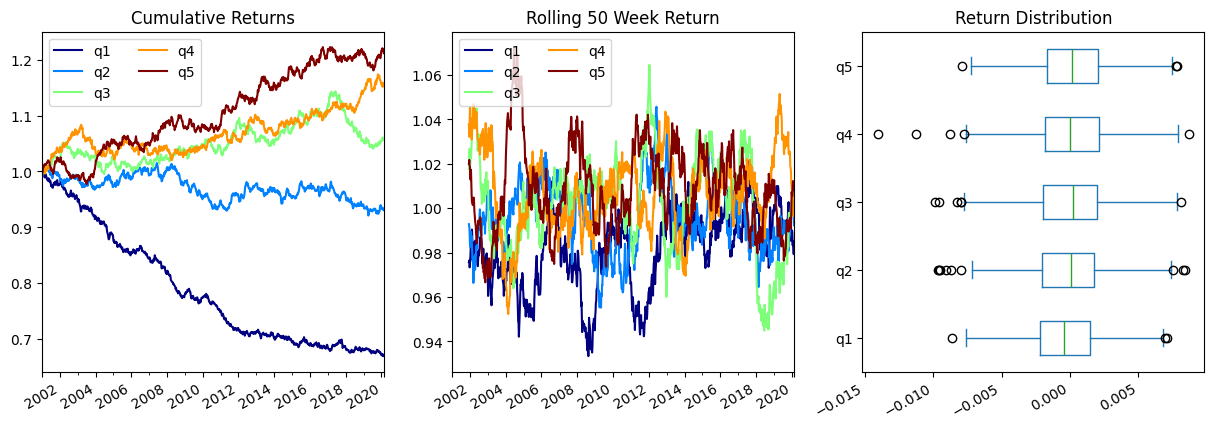

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1,3), (0,0))
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

# Cumulative Returns
returns_cut.add(1).cumprod() \
.plot(colormap='jet', ax=ax1, title="Cumulative Returns")
leg1 = ax1.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg1.get_frame().set_alpha(.8)

# Rolling 50 Week Return
returns_cut.add(1).rolling(50).apply(lambda x: x.prod()) \
.plot(colormap='jet', ax=ax2, title="Rolling 50 Week Return")
leg2 = ax2.legend(loc='upper left', ncol=2, prop={'size': 10}, fancybox=True)
leg2.get_frame().set_alpha(.8)

# Return Distribution
returns_cut.plot.box(vert=False, ax=ax3, title="Return Distribution")
fig.autofmt_xdate()
plt.show()

### Visualizar correlacion de quintiles con `scatter_matrix`

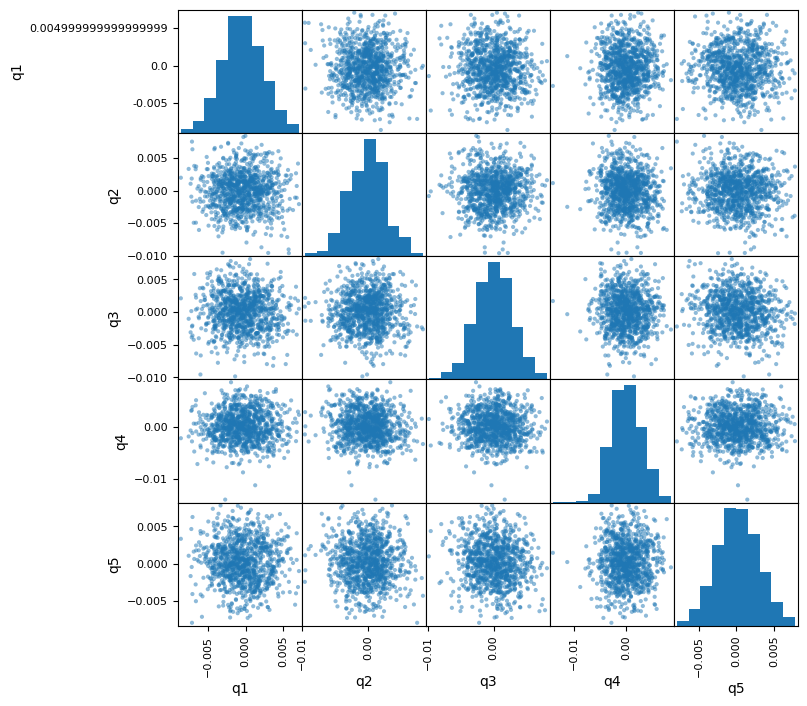

In [31]:
from pandas.plotting import scatter_matrix

scatter_matrix(returns_cut, alpha=0.5, figsize=(8, 8), diagonal='hist')
plt.show()

### Calcular y visualizar el maximo Drow Down

In [32]:
def max_dd(returns):
    """returns is a series"""
    r = returns.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = dd.argmin()
    start = r.loc[:end].argmax()
    return mdd, start, end

def max_dd_df(returns):
    """returns is a dataframe"""
    series = lambda x: pd.Series(x, ['Draw Down', 'Start', 'End'])
    return returns.apply(max_dd).apply(series)

Que hace esto como se ve

In [33]:
max_dd_df(returns_cut)

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [998] of type int64

> El error que estás viendo se debe a que estás intentando hacer indexación por segmento en un DatetimeIndex con un índice que es de tipo int64. Esto no es compatible y está causando el error TypeError. Es posible que necesites revisar tu código para asegurarte de que estás utilizando los tipos de índice correctos en tu operación de indexación.

## Calcular estadisticas

Hay varios potenciales estadisticos que podemos incluir. Abajo estan justo algunos cuantos, pero demostraremos como simplemente podemos incorporar nuevas estadisticas en nuestros resumenes.

In [35]:
def frequency_of_time_series(df):
    start, end = df.index.min(), df.index.max()
    delta = end - start
    return round((len(df) - 1.) * 365.25 / delta.days, 2)

def annualized_return(df):
    freq = frequency_of_time_series(df)
    return df.add(1).prod() ** (1 / freq) - 1

def annualized_volatility(df):
    freq = frequency_of_time_series(df)
    return df.std().mul(freq ** .5)

def sharpe_ratio(df):
    return annualized_return(df) / annualized_volatility(df)

def describe(df):
    r = annualized_return(df).rename('Return')
    v = annualized_volatility(df).rename('Volatility')
    s = sharpe_ratio(df).rename('Sharpe')
    skew = df.skew().rename('Skew')
    kurt = df.kurt().rename('Kurtosis')
    desc = df.describe().T
    return pd.concat([r, v, s, skew, kurt, desc], axis=1).T.drop('count')

Ahora terminaremos usando unicamente la funcion `describe()` como este empuja todos los otros juntos.

In [36]:
describe(returns_cut)

,q1,q2,q3,q4,q5
Return,-0.007609,-0.001375,0.001067,0.002821,0.003687
Volatility,0.019584,0.020445,0.020629,0.021185,0.020172
Sharpe,-0.388525,-0.067278,0.051709,0.133176,0.182792
Skew,0.040430,-0.085828,-0.078071,-0.067522,0.005652
Kurtosis,-0.174206,0.203038,0.026385,0.370249,-0.160678
mean,-0.000395,-0.000068,0.000060,0.000151,0.000196
std,0.002711,0.002830,0.002856,0.002933,0.002792
min,-0.008608,-0.009614,-0.009845,-0.014037,-0.007913
25%,-0.002196,-0.002018,-0.001956,-0.001833,-0.001694
50%,-0.000434,0.000065,0.000210,0.000029,0.000146


Esto no pretende ser exhaustivo. Su objetivo es reunir muchas de las características de los pandas y demostrar cómo puedes usarlos para responder preguntas importantes para ti. Este es un subconjunto de los tipos de métricas que utilizo para evaluar la eficacia de factores cuantitativos.

Lea el análisis: <a href='https://riptutorial.com/pandas/topic/5238/análisis--juntando-todo-y-tomando-decisiones'> Reuniéndolo todo y tomando decisiones en línea</a>:
